In [1]:
import numpy as np
import brainlit
import scipy
from brainlit.utils import swc
from cloudvolume.exceptions import SkeletonDecodeError
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph
from brainlit.algorithms.trace_analysis.spline_fxns import curvature, torsion
import os
from pathlib import Path
import pandas as pd
from networkx.readwrite import json_graph
import json
import matplotlib.pyplot as plt
import seaborn as sns

/cis/home/jteneggi/anaconda3/envs/cuda10/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


## Define brain, find trace data folder

In [2]:
#specify brain1 or brain2 below
brain = "brain1"

root_dir = Path(os.path.abspath('')).parents[1]
experiment_dir = os.path.join(root_dir, "axon_geometry")
data_dir = os.path.join(experiment_dir, "data", brain)
segments_swc_dir = os.path.join(data_dir, "segments_swc")
trace_data_dir = os.path.join(data_dir, "trace_data")
trace_data_dir = os.path.join(trace_data_dir, "14")
print(f"Directory where swcs reside: {segments_swc_dir}")

Directory where swcs reside: /cis/home/jteneggi/repo/brainlit/experiments/axon_geometry/data/brain1/segments_swc


## Read trace data

In [3]:
max_id = 300
seg_lengths = []
mean_torsions = []
mean_curvatures = []
d_from_root = []
torsions = []
curvatures = []

def classify_height(row):
    height = row["height"]
    if height <= 2:
        return height
    else:
        return 3

def numerical_class(row):
    _class = row["class"]
    if _class == "axon":
        return 0
    if _class == "collateral":
        return 1
    if _class == "terminal":
        return 2

df_path = os.path.join(trace_data_dir, "df.csv")
if os.path.exists(df_path):
    df = pd.read_csv(df_path)
else:
    df = pd.DataFrame(columns=["seg_id", "class", "height", "log_segment_length", "measure", "log_value"])
    for i in np.arange(0, max_id):
        i = int(i)
        trace_data_path = os.path.join(trace_data_dir, "{}.npy".format(i))
        if os.path.exists(trace_data_path) is True:
            trace_data = np.load(trace_data_path, allow_pickle=True)
            print("Loaded segment {}".format(i))

            for node in trace_data:
                # print(node)
                seg_length = node["seg_length"]
                height = node["height"]
                _class = node["class"]
                mean_curvature = node["mean_curvature"]
                mean_torsion = node["mean_torsion"]
                log_seg_length = np.log10(seg_length)
                if mean_curvature > 1e-16:
                    log_mean_curvature = np.log10(mean_curvature)
                    df = df.append({"seg_id": i, "height": height, "class": _class, "log_seg_length": log_seg_length, "measure": "curvature", "log_value": log_mean_curvature}, ignore_index=True)
                if mean_torsion > 1e-16:
                    log_mean_torsion = np.log10(mean_torsion)
                    df = df.append({"seg_id": i, "height": height, "class": _class, "log_seg_length": log_seg_length, "measure": "torsion", "log_value": log_mean_torsion}, ignore_index=True)
    df.to_csv(df_path)
df["class"] = df.apply(numerical_class, axis=1)
df["height_class"] = df.apply(classify_height, axis=1)

# Density of `log` segment lengths as a function of spline height class

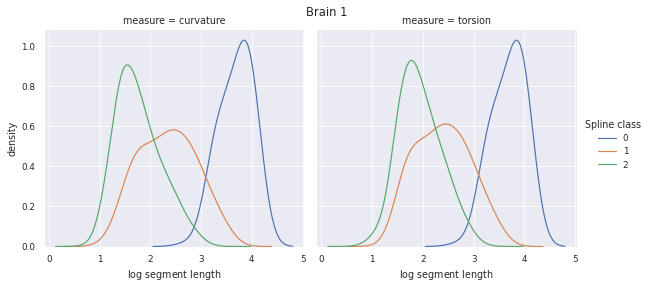

In [4]:
sns.set_theme()
sns.set_context("paper")

g = sns.FacetGrid(df, col="measure", hue="class", height=4)
g.map(sns.kdeplot, "log_seg_length", bw_adjust=1.8)
g.set_axis_labels(r"$\log$ segment length", "density")
g.add_legend(title="Spline class")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_seg_length_class_density.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_seg_length_class_density.jpg"))

# Density of `log` curvature/torsion as a function of spline height class

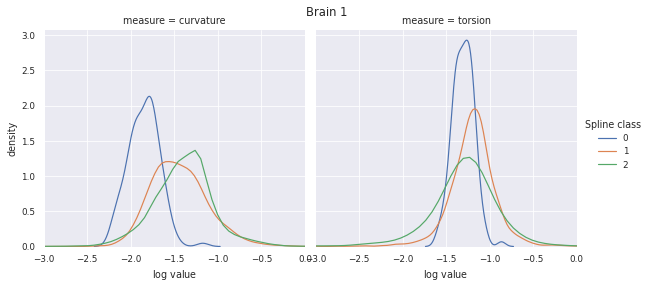

In [5]:
g = sns.FacetGrid(df, col="measure", hue="class", height=4)
g.map(sns.kdeplot, "log_value")
g.set_axis_labels(r"$\log$ value", "density")
g.add_legend(title="Spline class")
g.set(xlim=[-3, 0])
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_mean_value_class_density.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_mean_value_class_density.jpg"))

# Scatter plots of `log` curvature/torsion as a function of spline height class

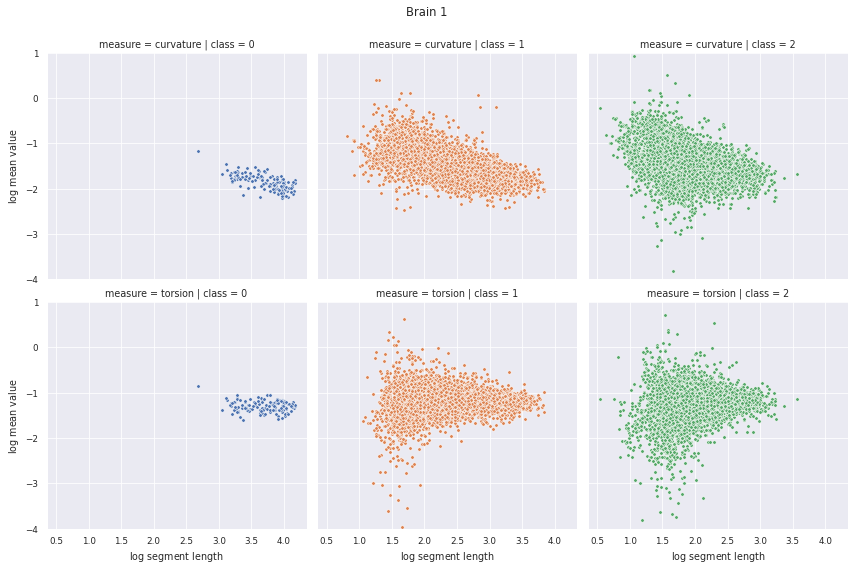

In [6]:
g = sns.FacetGrid(df, row="measure", col="class", hue="class", height=4)
g.map(sns.scatterplot, "log_seg_length", "log_value", marker='.', s=50)
g.set_axis_labels(r"$\log$ segment length", r"$\log$ mean value")
g.set(ylim=[-4, 1])
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_mean_value_class_scatter.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_mean_value_class_scatter.jpg"))

# Linear regression of `log` curvature/torsion as a function of spline height class

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

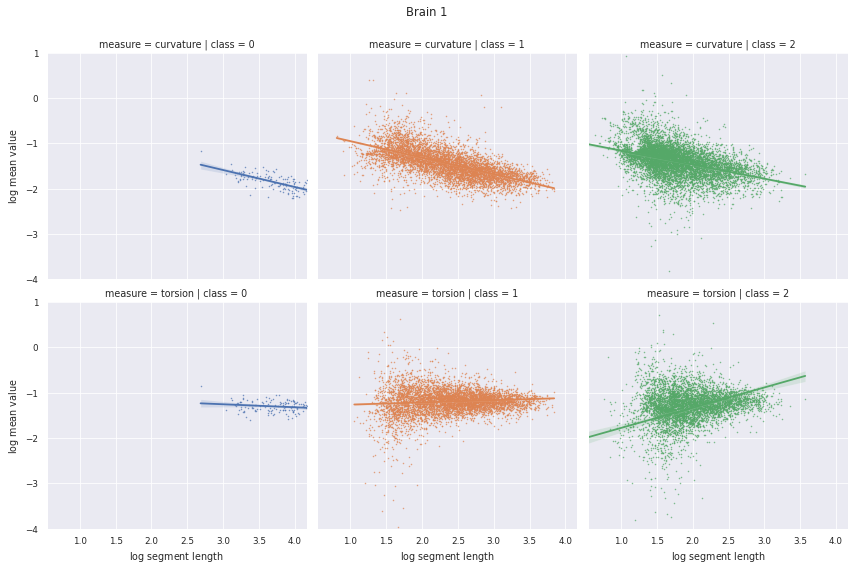

In [7]:
g = sns.FacetGrid(df, row="measure", col="class", hue="class", height=4)
g.map(sns.regplot, "log_seg_length", "log_value", marker='.', scatter_kws={'s':1})
g.set_axis_labels(r"$\log$ segment length", r"$\log$ mean value")
g.set(ylim=[-4, 1])
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_liear_regression_class.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_linear_regression_class.jpg"))

## Pairwise Wilcoxon Sum Ranked test and Kolgomorov-Smirnoff test

In [8]:
p_df = pd.DataFrame(columns=["measure", "first_sample", "second_sample", "wilcoxon_p", "ks_p"])

tests = {
    "wilcoxon": scipy.stats.mannwhitneyu,
    "ks": scipy.stats.kstest, 
}
measures = ["curvature", "torsion"]
classes = {0: "axon", 1: "collateral", 2: "terminal"}
n = len(classes)
matrix_pairs = np.triu(np.ones((n, n)), k=1)
(coord_pairs_x, coord_pairs_y) = np.where(matrix_pairs == 1)

for test_name in tests:
    test_f = tests[test_name]
    for measure in measures:
        for x, y in zip(coord_pairs_x, coord_pairs_y):
            first_sample_query = df.loc[(df['class'] == x) & (df['measure'] == measure)]
            second_sample_query = df.loc[(df['class'] == y) & (df['measure'] == measure)]
            
            first_sample = first_sample_query["log_value"].to_numpy()
            second_sample = second_sample_query["log_value"].to_numpy()
            
            test_column = f"{test_name}_p"
            _, test_p = test_f(first_sample, second_sample)
            print(f"{test_name} test, measure = {measure}, {classes[x]} vs {classes[y]}, p_value = {test_p}")
            
            p_df = p_df.append({"measure": measure, "first_sample": x, "second_sample": y, test_column: test_p}, ignore_index=True)

wilcoxon test, measure = curvature, axon vs collateral, p_value = 3.395676430729673e-48
wilcoxon test, measure = curvature, axon vs terminal, p_value = 3.254222266562562e-53
wilcoxon test, measure = curvature, collateral vs terminal, p_value = 7.684944273119543e-32
wilcoxon test, measure = torsion, axon vs collateral, p_value = 1.7625903927025968e-12
wilcoxon test, measure = torsion, axon vs terminal, p_value = 0.07458611095497056
wilcoxon test, measure = torsion, collateral vs terminal, p_value = 9.947988105503337e-67
ks test, measure = curvature, axon vs collateral, p_value = 1.3845702884065158e-47
ks test, measure = curvature, axon vs terminal, p_value = 2.4137727079039203e-64
ks test, measure = curvature, collateral vs terminal, p_value = 1.6653345369377348e-15
ks test, measure = torsion, axon vs collateral, p_value = 3.219646771412954e-15
ks test, measure = torsion, axon vs terminal, p_value = 4.2525116661362716e-07
ks test, measure = torsion, collateral vs terminal, p_value = 4.5